In [37]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint
import numpy.random as rng
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./data/", one_hot = False)


def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

def preprocee_mnist(images, labels):
    min_num = 60000
    for i in range(0, 10):
        min_num = min(min_num, len(np.where(labels == i)[0]))
    dataset = np.zeros((10, min_num, 28, 28))
    idx_arr = np.zeros((10,1),dtype=int)
    for idx in range(images.shape[0]):
        if(idx_arr[int(labels[idx])] < min_num):
            dataset[int(labels[idx]), idx_arr[labels[idx]], :, :] = np.reshape(images[idx],(28,28))
            idx_arr[labels[idx]] += 1
    return dataset[0:3,:,:,:] # Using 0-2 temporarily， 0-9 can also be used, but more training time is needed

input_shape = (28, 28, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(3,3),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(1e-4)))
convnet.add(Conv2D(128,(3,3),activation='relu',
                   kernel_regularizer=l2(1e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(32,(3,3),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(1e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(128,activation="sigmoid",kernel_regularizer=l2(1e-4),kernel_initializer=W_init,bias_initializer=b_init))
#encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#merge two encoded inputs with the l1 distance between them
L1_distance = lambda x: (x[0]-x[1])
both = merge([encoded_l,encoded_r], mode = L1_distance, output_shape=lambda x: x[0])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(both)


siamese_net = Model(input=[left_input,right_input],output=prediction)
# optimizer = SGD(0.0004,momentum=0.6,nesterov=True,decay=0.0003)
optimizer = Adam(0.0001)
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()


Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:58: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:62: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`


521249

In [38]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self,Xtrain,Xval):
        self.Xval = Xval
        self.Xtrain = Xtrain
        self.n_classes,self.n_examples,self.w,self.h = Xtrain.shape
        self.n_val,self.n_ex_val,_,_ = Xval.shape

    def get_batch(self,n):
        """Create batch of n pairs, half same class, half different class"""
        categories = rng.choice(self.n_classes,size=(n,),replace=False)
        pairs=[np.zeros((n, self.h, self.w,1)) for i in range(2)]
        targets=np.zeros((n,))
        targets[n//3:] = 1
        for i in range(n):
            category = categories[i]
            idx_1 = rng.randint(0,self.n_examples)
            pairs[0][i,:,:,:] = self.Xtrain[category,idx_1].reshape(self.w,self.h,1)
            idx_2 = rng.randint(0,self.n_examples)
            #pick images of same class for 1st half, different for 2nd
            category_2 = category if i > n//3 else (category + rng.randint(1,self.n_classes-1)) % self.n_classes
            if category_2 < category:
                targets[i] = 0
            elif category_2 > category:
                targets[i] = 1
            else:
                targets[i] = 0.5
            pairs[1][i,:,:,:] = self.Xtrain[category_2,idx_2].reshape(self.w,self.h,1)
        return pairs, targets

    def make_oneshot_task(self,N):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        categories = rng.choice(self.n_val, size=(N,),replace=False)
        indices = rng.randint(0,self.n_ex_val,size=(N,))
        true_category = categories[0]
        ex1, ex2 = rng.choice(self.n_ex_val,replace=False,size=(2,))
        test_image = np.asarray([self.Xval[true_category,ex1,:,:]]*N).reshape(N,self.w,self.h,1)
        support_set = self.Xval[categories,indices,:,:]
        support_set[0,:,:] = self.Xval[true_category,ex2]
        support_set = support_set.reshape(N,self.w,self.h,1)
        pairs = [test_image,support_set]
        print true_category
        print categories
        targets = np.zeros((N,))
        targets[0] = 1
        return pairs, targets, true_category, categories

    def test_oneshot(self,model,N,k,verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        TEST_THRES = 0.3
        if verbose:
            print("Evaluating model on {} unique {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets, true_category, categories = self.make_oneshot_task(N)
            probs = model.predict(inputs)
            print probs
            correct = True
            for idx in range(0, len(probs)):
                if TEST_THRES < probs[idx] and probs[idx] < 1-TEST_THRES and true_category == categories[idx]:
                    correct = correct and True
                elif TEST_THRES <= probs[idx] and categories[idx] > true_category:
                    correct = correct and True
                elif TEST_THRES >= probs[idx] and categories[idx] < true_category:
                    correct = correct and True
                else:
                    correct = False
                    break
            if correct == True:
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct, inputs

In [ ]:
# Training and Refine the model
evaluate_every = 100
loss_every=300
batch_size = 3
N_way = 3
n_val = 3
K.get_session().run(tf.global_variables_initializer())
# siamese_net.load_weights("./model/model.hdf5") # Refine the model with an trained model
best = 0.0

train_set = preprocee_mnist(mnist.train.images, mnist.train.labels)
val_set = preprocee_mnist(mnist.validation.images, mnist.validation.labels)
loader = Siamese_Loader(train_set, val_set)

for i in range(1100000):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=siamese_net.train_on_batch(inputs,targets)
    if i % evaluate_every == 0:
        val_acc, _ = loader.test_oneshot(siamese_net,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("saving")
            siamese_net.save('./model/model.hdf5')
            best=val_acc

    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))

0
[0 2 1]
[[ 0.53272241]
 [ 0.9997316 ]
 [ 0.99425703]]
(3, 28, 28, 1)


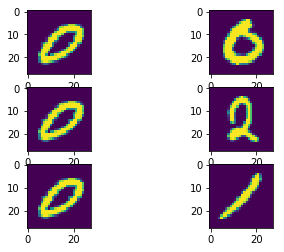

Got an accuracy of 100.0%


In [42]:
# Testing Phrase
import matplotlib.pyplot as plt
TEST_THRES = 0.3
train_set = preprocee_mnist(mnist.train.images, mnist.train.labels)
val_set = preprocee_mnist(mnist.validation.images, mnist.validation.labels)
siamese_net.load_weights('./model/model.hdf5')
loader = Siamese_Loader(train_set, train_set)
correct = 0
num_pairs = 1
for i in range(num_pairs):
    res, inputs = loader.test_oneshot(model = siamese_net, N = 3, k = 1,verbose=0)
    print inputs[0].shape
    if res == 100:
        correct += 1
    plt.subplot(3,2,1)
    plt.imshow(inputs[0][0][:,:,0])
    plt.subplot(3,2,2)
    plt.imshow(inputs[1][0][:,:,0])
    plt.subplot(3,2,3)
    plt.imshow(inputs[0][1][:,:,0])
    plt.subplot(3,2,4)
    plt.imshow(inputs[1][1][:,:,0])
    plt.subplot(3,2,5)
    plt.imshow(inputs[0][2][:,:,0])
    plt.subplot(3,2,6)
    plt.imshow(inputs[1][2][:,:,0])
    plt.show()
print("Got an accuracy of {}%".format(100.0 * correct/num_pairs))